In [ ]:
pip install ipdb

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
import ipdb
import warnings
import time
warnings.filterwarnings("ignore")

In [43]:
#ADMM for solving min_x ||D_1x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D TV sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e-1,rho=1):
  #the choice of rho must be careful!
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda = sp.sparse.diags(scipy.fft.fft(a),0) #eigenvector of D1
  x = y#np.random.randn(N,)
  z = np.random.randn(N,)
  u = np.random.randn(N,)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda.conjugate()@Lambda).diagonal()
  invD = sp.sparse.diags(1/d,0)
  #ipdb.set_trace()
  if constrain == True:
    for i in range(maxit):
      #x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*sp.sparse.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      x = np.maximum(x,0)
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>50 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
      #if np.mod(i,1000) == 0:
      #  print(i)
  else: 
    for i in range(maxit):
      #x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>100 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
  return x,err,loss
def l1solv(Fw1,meas,constraint=True,epsilon=1e0):
# Create variable.
   N = len(meas)
   D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
   D1[0,-1] = -1
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D1@x_l1, 1) + epsilon*cp.norm((Fw1@x_l1)-meas, 2)**2)
# Form and solve problem.
   if constraint == False:
    prob = cp.Problem(obj)
   else:
     prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   #plt.plot(x_l1.value,'y')
   #plt.plot(u,'c')
   #plt.plot(meas,'r')
   mx_norm = torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 2))**2*1e-4
   #psnr_recon = psnr2(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)
def makeA2d(n=10,alpha=20):
    s = 1/(2*alpha)
    N = n**2
    A = (1-4*s)*sp.sparse.diags(np.ones((N,)),0) + s*sp.sparse.diags(np.ones((N-1,)),-1) + s*sp.sparse.diags(np.ones((N-1,)),1) \
        + s*sp.sparse.diags(np.ones((N-n,)),n) + s*sp.sparse.diags(np.ones((N-n,)),-n) + s*sp.sparse.diags(np.ones((n,)),N-n) + s*sp.sparse.diags(np.ones((n,)),n-N)
    A[0,-1] = s
    A[-1,0] = s
    return A
def inside_ellipse(N, theta, ax1, ax2):
    """
    returns a boolean image marking the pixels inside the given ellipse
    """
    x, y = torch.meshgrid(torch.linspace(-1, 1, N), torch.linspace(-1, 1, N))
    x_rot = torch.cos(theta)*x + torch.sin(theta)*y
    y_rot = -torch.sin(theta)*x + torch.cos(theta)*y
    return x_rot**2 / ax1**2 + y_rot**2 / ax2**2 < 1

def make_im(N, thetas, ax1s, ax2s):
    im = torch.zeros(N,N)  

    for ax1, ax2, theta in zip(ax1s, ax2s, thetas):
        im[inside_ellipse(N, theta, ax1, ax2)] += 1
    im = im/im.max()
    return im

In [3]:
# define the image size and the parameters of the ellipses
n = 256
N = n**2
ax1s = [0.2, 0.5]  # solution (anything else is fine)
ax2s = [0.9, 0.7]  # solution
thetas = torch.tensor([0.4*math.pi, 0.4*math.pi])  # solution
im = make_im(n, thetas, ax1s, ax2s).numpy().reshape(n,n).T  # ground truth image

In [4]:
alpha=20
Ncount=50
imres=im.reshape(N,)
A2d=makeA2d(n,alpha)
Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A2d[0,:].toarray().reshape(N,))))
#F = sp.fft.fft(np.eye(N))/np.sqrt(N) 
#Fw = np.real(F@(Sigma**Ncount@F.conjugate())/np.sqrt(1))
#Fw = np.real(sp.fft.fft(Sigma**Ncount@F.conjugate(),axis=0)/np.sqrt(N))
#Fw = np.linalg.matrix_power(A2d.toarray(), Ncount)
mres=np.real(sp.fft.fft((Sigma**Ncount@sp.fft.fft(imres).conjugate()).reshape(N,))/N)
meas=mres.reshape(n,n)

In [13]:
#C = makeA2d(3,alpha)
#C.toarray()
#F = sp.fft.fft(np.eye(9))/np.sqrt(9 )
#Sigma = sp.sparse.diags(np.real(scipy.fft.fft(C[0,:].toarray().reshape(9,))),0)
#np.linalg.norm(C-np.real(F@(Sigma@F.conjugate())/np.sqrt(1)))
#print(np.real(sp.fft.fft(Sigma@F.conjugate())/np.sqrt(9)))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb522c54ad0>,
 <matplotlib.image.AxesImage at 0x7fb4b6defdd0>)

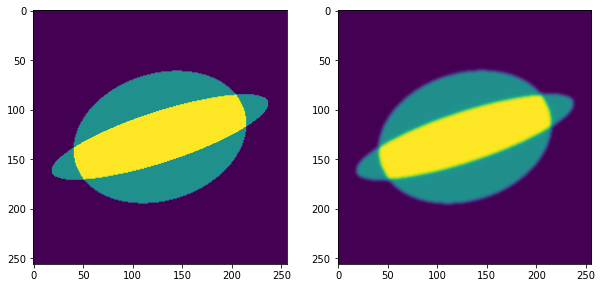

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(meas)

In [29]:
n1 = 4
N1 = n1**2
D2 = sp.sparse.diags(np.ones((N1,)),0) - sp.sparse.diags(np.ones((N1-n1,)),n1) - sp.sparse.diags(np.ones((n1,)),n1-N1) 
D2.toarray().astype(np.int)

array([[ 1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [30]:
t = np.linspace(1,200,20)
a =[]
b =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    #u_rec = l1solv(np.linalg.matrix_power(A.toarray(),int(t[ti])),meas1,constraint=False,epsilon=1e-1)
    u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e1)
    mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 #+ 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im.reshape(N,),u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 1.0 psnr 28.864883253888586 mixed norm: 3911.614696992695
N: 11.473684210526315 psnr 29.4388878508052 mixed norm: 4108.462590760495
N: 21.94736842105263 psnr 29.845734890330476 mixed norm: 4320.5807519901055
N: 32.421052631578945 psnr 31.013182525224213 mixed norm: 4640.2453632708775
N: 42.89473684210526 psnr 40.002296022604604 mixed norm: 4338.341742446194
N: 53.368421052631575 psnr 30.153417350836225 mixed norm: 8962.838539035658
N: 63.84210526315789 psnr 20.030854796032447 mixed norm: 13622.418529102344
N: 74.3157894736842 psnr 16.03522801281799 mixed norm: 15962.730031083785
N: 84.78947368421052 psnr 14.642074857343918 mixed norm: 17300.11991612503


KeyboardInterrupt: ignored

0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb4ade0d690>,
 Text(0.5, 1.0, 'original signal'))

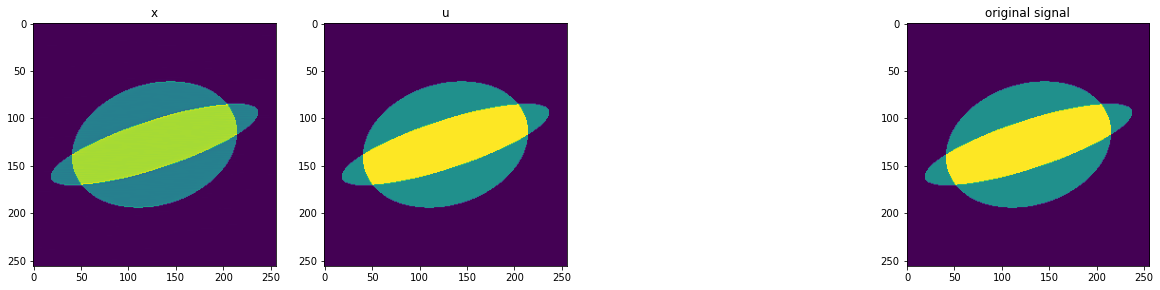

In [10]:
N_recon = 10#np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),im.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=1e1)
#x_cvx = l1solv(np.linalg.matrix_power(A2d.toarray(),int(N_recon)),im.reshape(N,1),constraint=True,epsilon=1e1)
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im),plt.title('u')
#plt.subplot(143),plt.imshow(x_cvx.reshape(n,n)),plt.title('x_cvx')
plt.subplot(144),plt.imshow(im),plt.title('original signal')

psnr 36.33219339415899


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb4a6771fd0>,
 Text(0.5, 1.0, 'original signal'))

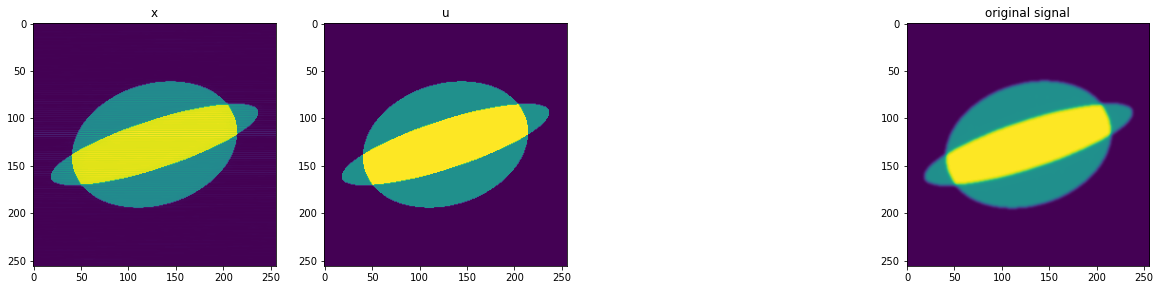

In [45]:
N_recon = 50#np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),meas.reshape(N,1),constrain=True,rho=1,maxit=500,epsilon=1e1)
print('psnr',psnr2(x,im.reshape(N,)))
#x_cvx = l1solv(np.linalg.matrix_power(A2d.toarray(),int(N_recon)),im.reshape(N,1),constraint=True,epsilon=1e1)
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im),plt.title('u')
#plt.subplot(143),plt.imshow(x_cvx.reshape(n,n)),plt.title('x_cvx')
plt.subplot(144),plt.imshow(meas),plt.title('original signal')

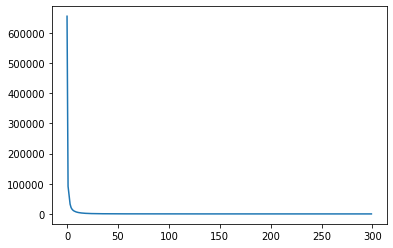

In [36]:
plt.plot(loss)

In [158]:
u_rec.shape

(1089,)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f425f488a10>,
 Text(0.5, 1.0, 'original signal'))

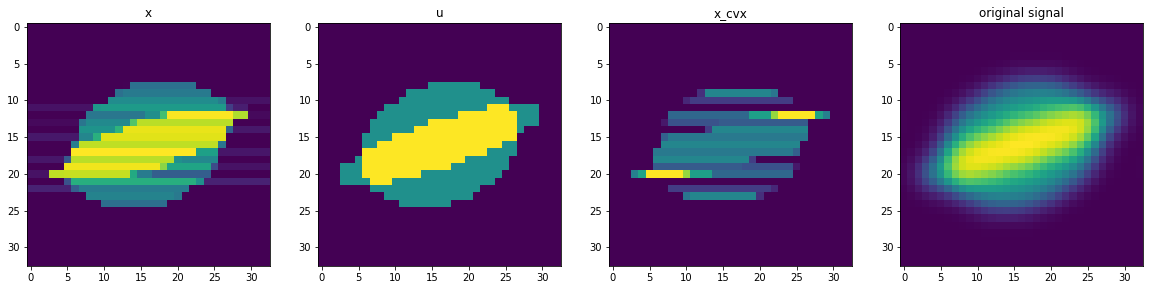

In [150]:
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im),plt.title('u')
plt.subplot(143),plt.imshow(x_cvx.reshape(n,n)),plt.title('x_cvx')
plt.subplot(144),plt.imshow(meas),plt.title('original signal')

In [135]:
psnr2(mres.reshape(N,),im.reshape(N,))

19.865070283782188

In [152]:
print('cvx loss',np.linalg.norm(D1@x_cvx, 1)+ np.linalg.norm((np.linalg.matrix_power(A2d.toarray(),int(50))@x_cvx)-mres.reshape(N,1), 2)**2*1e1)
print('ADMM loss',np.linalg.norm(D1@x, 1)+ np.linalg.norm((np.linalg.matrix_power(A2d.toarray(),int(50))@x)-mres.reshape(N,), 2)**2*1e1)

cvx loss 45.25322909965766
ADMM loss 25.865059845067552


In [151]:
(np.linalg.matrix_power(A2d.toarray(),int(50))@x).shape

(1089,)

In [75]:
def make_conv(h, n):
    """
    Return a matrix, H, that implements convolution of a length-n signal by h

    if h is length-m, the length of the (valid) convoluation result
    is n-m+1, so H has shape (n-m+1, n)

    h = [1.0, -1.0], n = 4 ->
    H =
    [[-1, 1, 0, 0,],
     [0, -1, 1, 0,],
     [0, 0, -1, 1,]]

    """
    assert h.ndim == 1

    m = len(h)
    pad = n-m # adds to beginning and end
    h_repeat = torch.nn.functional.unfold(
               torch.from_numpy(h).view(1, 1, -1, 1), (n, 1),
               padding=(pad, 0))
    return h_repeat[0].T.flip(1).numpy()


In [79]:
import numpy as np
N1=3
n=N1**2
m = int(np.sqrt(n))
assert m**2 == n  # n must be perfect square
print(m)
W_horizontal = make_conv(np.array([1.0, -1.0]), n)
W_horizontal = np.delete(W_horizontal, slice(m-1, None, m), axis=0)

h = np.zeros(m+1)
h[0] = -1.0
h[-1] = 1.0
W_vertical = make_conv(h, n)
W = np.concatenate((W_horizontal, W_vertical), axis=0)
print(W)

3
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.]
 [ 1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -1.]]
